In [2]:
# Neural Ordinary Differential Equations (Neural ODEs) in JAX
#
# This script demonstrates how to build and train a Neural ODE using JAX,
# Equinox, and Diffrax. The goal is to learn the continuous-time dynamics
# of a synthetic 2D dataset, such as a spiral or concentric circles.

# 1. Imports and Setup
#
# First, we import all the necessary libraries. We'll be using:
# - `jax` for numerical computation and automatic differentiation.
# - `equinox` for building the neural network in a PyTorch-like fashion.
# - `diffrax` for the high-performance ODE solver.
# - `optax` for optimization.
# - `matplotlib` for plotting.

In [3]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt
import matplotlib.pyplot as plt

In [4]:
# 2. Data Loading
#
# This section contains the functions to generate our synthetic datasets.
# We can create either a spiral or concentric circles. These functions will
# be used to create the data points (x, y) that our model will learn to
# classify by transforming them over time.

In [5]:
def get_data(dataset_name, data_size, key):
    """
    Generates synthetic datasets.
    
    Args:
        dataset_name (str): "spiral" or "circle".
        data_size (int): The number of data points per class.
        key (jax.random.PRNGKey): JAX random key.
        
    Returns:
        ts (jnp.ndarray): Time points for integration.
        ys (jnp.ndarray): Data points with class labels.
        key (jax.random.PRNGKey): Updated JAX random key.
    """
    if dataset_name == "spiral":
        return make_spiral(data_size, key)
    elif dataset_name == "circle":
        return make_concentric_circles(data_size, key)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

In [6]:
def make_spiral(data_size, key):
    """Generates a 2D spiral dataset."""
    n = data_size
    key, r_key, theta_key, noise_key = jrandom.split(key, 4)
    
    theta0 = jnp.sqrt(jrandom.uniform(r_key, (n, 1))) * 3 * jnp.pi
    r0 = theta0 / (3 * jnp.pi) + 0.05
    x0 = jnp.append(r0 * jnp.cos(theta0), r0 * jnp.sin(theta0), axis=1)
    y0 = jnp.zeros((n, 1))

    theta1 = jnp.sqrt(jrandom.uniform(theta_key, (n, 1))) * 3 * jnp.pi
    r1 = theta1 / (3 * jnp.pi) + 0.05
    x1 = jnp.append(-r1 * jnp.cos(theta1), -r1 * jnp.sin(theta1), axis=1)
    y1 = jnp.ones((n, 1))

    x = jnp.concatenate([x0, x1])
    y = jnp.concatenate([y0, y1]).ravel()
    
    x += jrandom.normal(noise_key, x.shape) * 0.1
    ts = jnp.array([0.0, 1.0])
    ys = (x, y)
    
    return ts, ys, key

In [7]:
def make_concentric_circles(data_size, key):
    """Generates a 2D concentric circles dataset."""
    n = data_size
    key, angle_key1, angle_key2, noise_key1, noise_key2 = jrandom.split(key, 5)

    radius0 = 1.0
    angles0 = jrandom.uniform(angle_key1, (n,)) * 2 * jnp.pi
    x0 = radius0 * jnp.cos(angles0)
    y0_coord = radius0 * jnp.sin(angles0)
    class0 = jnp.stack([x0, y0_coord], axis=1)
    class0 += jrandom.normal(noise_key1, class0.shape) * 0.1
    labels0 = jnp.zeros(n)

    radius1 = 2.0
    angles1 = jrandom.uniform(angle_key2, (n,)) * 2 * jnp.pi
    x1 = radius1 * jnp.cos(angles1)
    y1_coord = radius1 * jnp.sin(angles1)
    class1 = jnp.stack([x1, y1_coord], axis=1)
    class1 += jrandom.normal(noise_key2, class1.shape) * 0.1
    labels1 = jnp.ones(n)
    
    x = jnp.concatenate([class0, class1])
    y = jnp.concatenate([labels0, labels1])

    ts = jnp.array([0.0, 1.0])
    ys = (x, y)

    return ts, ys, key

In [8]:
# 3. Model Definition
#
# Here, we define the core components of our Neural ODE.
#
# - **`ODEFunc`**: This is a simple MLP that represents the function `f` in
#   the differential equation `dz/dt = f(z, t; θ)`. It learns the vector
#   field that transforms the data.
# - **`NeuralODE`**: This module wraps the `ODEFunc` and the `diffrax`
#   solver. Its `__call__` method takes an initial state `y0` and time
#   points `ts`, and returns the solution of the ODE at those time points

In [9]:
class ODEFunc(eqx.Module):
    """
    Represents the function f(z, t; theta) in the Neural ODE.
    This is a simple MLP.
    """
    mlp: eqx.nn.MLP

    def __init__(self, key):
        self.mlp = eqx.nn.MLP(
            in_size=2,
            out_size=2,
            width_size=64,
            depth=2,
            activation=jnp.tanh,
            key=key
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

In [10]:
class NeuralODE(eqx.Module):
    """
    Defines the Neural Ordinary Differential Equation model.
    """
    func: ODEFunc
    solver: Dopri5
    
    def __init__(self, key):
        self.func = ODEFunc(key)
        self.solver = Dopri5()

    def __call__(self, y0, ts):
        """
        Solves the ODE from y0 at times ts.
        """
        solution = diffeqsolve(
            terms=ODETerm(self.func),
            solver=self.solver,
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            saveat=SaveAt(ts=ts)
        )
        return solution.ys

In [11]:
# 4. Training and Visualization
#
# This section contains the logic for training the model.
#
# - **`grad_loss`**: A function that computes the loss (binary
#   cross-entropy) and its gradients with respect to the model's parameters.
# - **`train`**: The main training loop. It iterates for a number of steps,
#   samples batches of data, computes gradients, and updates the model
#   parameters using the Adam optimizer.
# - **`visualize_dynamics`**: A helper function to plot the learned vector
#   field and the trajectories of data points after training is complete.
#   This gives us insight into what the model has learned.

In [13]:
@eqx.filter_value_and_grad
def grad_loss(model, x, y, ts):
    """
    Computes the gradient of the loss with respect to the model parameters.
    """
    y_pred = jax.vmap(model, in_axes=(0, None))(x, ts)
    logits = y_pred[:, 1, 0] 
    return optax.sigmoid_binary_cross_entropy(logits, y).mean()

In [15]:
def train(model: NeuralODE, ts, ys, num_steps, batch_size, learning_rate, key):
    """
    Training loop for the Neural ODE.
    """
    optim = optax.adam(learning_rate)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    
    x_all, y_all = ys
    dataset_size = x_all.shape[0]
    
    loss_history = []

    for step in range(num_steps):
        key, subkey = jrandom.split(key)
        
        # Sample a batch
        indices = jrandom.choice(subkey, dataset_size, (batch_size,), replace=False)
        x_batch = x_all[indices]
        y_batch = y_all[indices]
        loss, grads = grad_loss(model, x_batch, y_batch, ts)
        
        # Update model
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        
        loss_history.append(loss.item())

        if step % 100 == 0 or step == num_steps - 1:
            print(f"Step: {step}, Loss: {loss.item():.4f}")

    visualize_dynamics(model, ys, ts)
    
    return model, loss_history

In [16]:
def visualize_dynamics(model, ys, ts):
    """
    Visualizes the learned dynamics of the Neural ODE.
    """
    x_data, y_data = ys
    
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 20), jnp.linspace(y_min, y_max, 20))
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=1)
    dz_dt = jax.vmap(model.func, in_axes=(None, 0, None))(0.0, grid_points, None)

    num_trajectories = 50
    trajectory_ts = jnp.linspace(ts[0], ts[-1], 50)
    trajectories = jax.vmap(model, in_axes=(0, None))(x_data[:num_trajectories], trajectory_ts)

    plt.figure(figsize=(10, 10))
    plt.quiver(grid_points[:, 0], grid_points[:, 1], dz_dt[:, 0], dz_dt[:, 1], color="gray", alpha=0.6)
    for i in range(num_trajectories):
        plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], '-', lw=1, color='blue', alpha=0.5)

    plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap='viridis', edgecolors='k')
    
    plt.title("Learned Dynamics and Trajectories")
    plt.xlabel("z_1")
    plt.ylabel("z_2")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()


In [17]:
# 5. Main Execution Block
#
# This is the main part of the script where we set hyperparameters,
# generate the data, initialize the model, and start the training process.
# Finally, we plot the training loss over time.

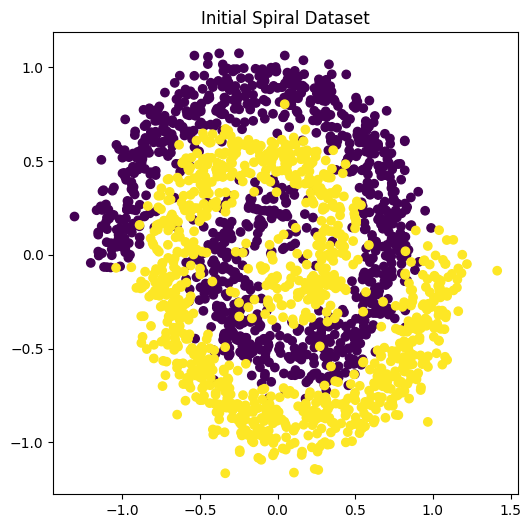

Starting training...
Step: 0, Loss: 0.6946
Step: 100, Loss: 0.4258
Step: 200, Loss: 0.3622
Step: 300, Loss: 0.2482
Step: 400, Loss: 0.2182
Step: 500, Loss: 0.2205
Step: 600, Loss: 0.1675
Step: 700, Loss: 0.1790
Step: 800, Loss: 0.1416
Step: 900, Loss: 0.1744
Step: 1000, Loss: 0.1802
Step: 1100, Loss: 0.1488
Step: 1200, Loss: 0.1956
Step: 1300, Loss: 0.2018
Step: 1400, Loss: 0.2064
Step: 1500, Loss: 0.2259
Step: 1600, Loss: 0.1363
Step: 1700, Loss: 0.2730
Step: 1800, Loss: 0.1784
Step: 1900, Loss: 0.2421
Step: 1999, Loss: 0.1644


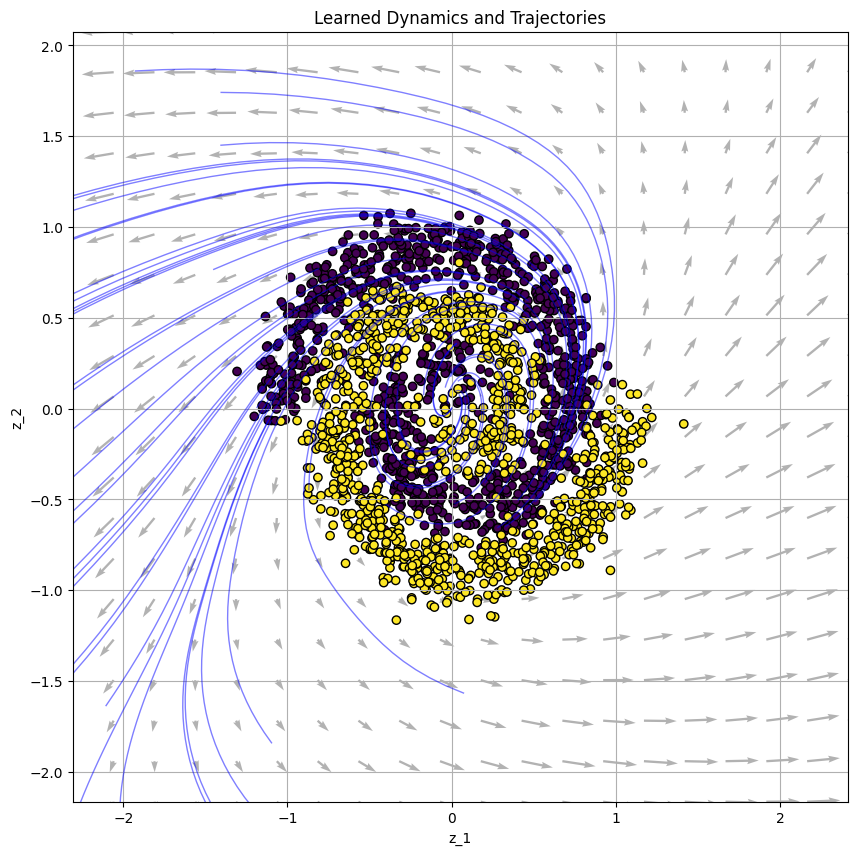

Training finished.


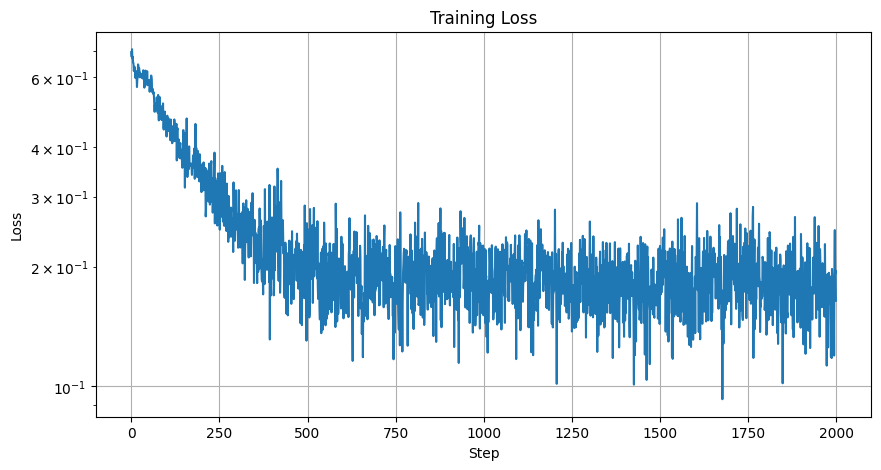

In [18]:
if __name__ == '__main__':
    learning_rate = 3e-3
    num_steps = 2000
    dataset_name = "spiral"
    data_size = 1000
    batch_size = 256
    seed = 42

    key = jrandom.PRNGKey(seed)
    data_key, model_key, train_key = jrandom.split(key, 3)

    ts, ys, data_key = get_data(dataset_name, data_size, data_key)
    plt.figure(figsize=(6, 6))
    plt.scatter(ys[0][:, 0], ys[0][:, 1], c=ys[1], cmap='viridis')
    plt.title(f"Initial {dataset_name.capitalize()} Dataset")
    plt.show()

    model = NeuralODE(key=model_key)

    print("Starting training...")
    model, loss_history = train(model, ts, ys, num_steps, batch_size, learning_rate, train_key)
    print("Training finished.")

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.grid(True)
    plt.show()